# RoBERTa study

Built off of Sentiment Analysis Python 🤗 [Youtube Tutorial]\
(https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook) \
\
RoBERTa model citation: \
Francesco Barbieri, Jose Camacho-Collados, Luis Espinosa Anke, and Leonardo Neves. 2020. TweetEval: Unified Benchmark and Comparative Evaluation for Tweet Classification. In *Findings of the Association for Computational Linguistics: EMNLP 2020*, pages 1644–1650, Online. Association for Computational Linguistics.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

plt.style.use('ggplot')

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [ ]:
# Read in data

df = pd.read_csv('/data/raw/Reviews.csv')

In [ ]:
# Show the first few rows

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# View the text from the first row

df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
# Check the size of the dataset

print(df.shape)

(568454, 10)


In [ ]:
# Let's only use the first 500 rows for now
df = df.head(500)
print(df.shape)

(500, 10)


## Let's get an idea of what this dataset looks like

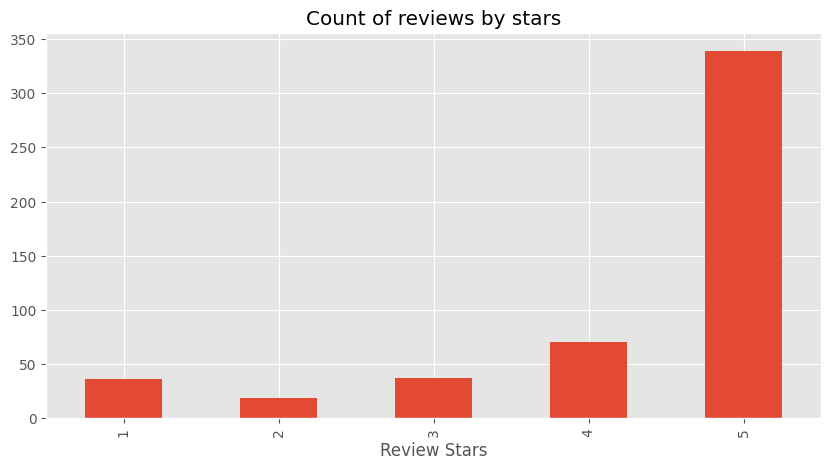

In [ ]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of reviews by stars',
          figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

## Playing with NLTK

In [ ]:
#Pick an example

example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [ ]:
# Print the tokenized example

tokens = nltk.word_tokenize(example, preserve_line=True) # Throws an error without preserve_line=True
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good.', 'Its', 'mushy', ',', 'soft', ',']

In [ ]:
# Get the parts of speech of the tokens

tagged = nltk.pos_tag(tokens) # use tagset='universal' uses words instead of symbols
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good.', 'VB'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ',')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint() # Pretty print because entities is of type <class 'nltk.tree.tree.Tree'>

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good./VB
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it./JJ
  (PERSON Quaker/NNP Oats/NNP)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


In [ ]:
print(type(entities))

<class 'nltk.tree.tree.Tree'>


## Roberta from Huggingface

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

from tqdm.notebook import tqdm # Progress bar tracker

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [ ]:
# Download the model and tokenizer

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt') # 'pt' is for pytorch
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
# Study how this output looks
print(output)
print(output[0])
print(output[0][0])
print(output[0][0].detach())

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>)
tensor([ 3.1436, -0.7107, -2.6559], grad_fn=<SelectBackward0>)
tensor([ 3.1436, -0.7107, -2.6559])


In [ ]:
# Output is a tensor, so store it as a numpy array

scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [ ]:
# Turn this code into a function we can run on any bit of text

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt') # 'pt' is for pytorch
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')

In [ ]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Original analysis

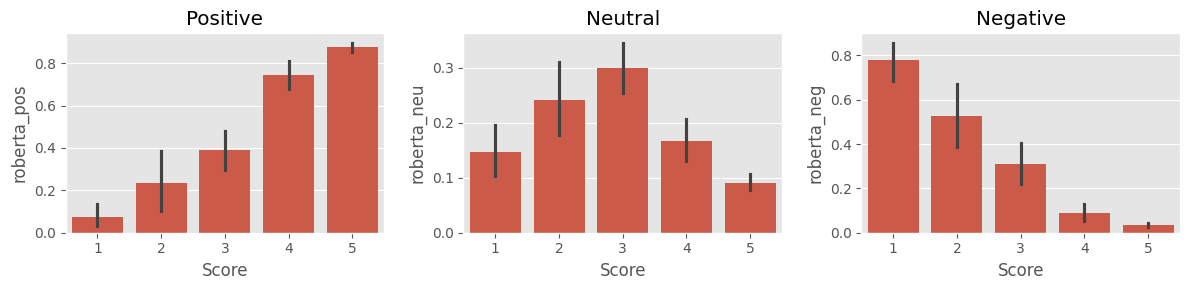

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

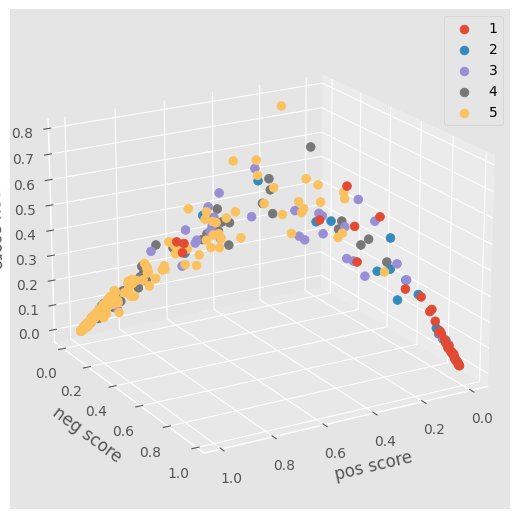

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

cut1 = results_df['Score']==1
cut2 = results_df['Score']==2
cut3 = results_df['Score']==3
cut4 = results_df['Score']==4
cut5 = results_df['Score']==5

sc = ax.scatter(results_df['roberta_pos'][cut1], results_df['roberta_neg'][cut1], results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1, label = '1')
sc = ax.scatter(results_df['roberta_pos'][cut2], results_df['roberta_neg'][cut2], results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1, label = '2')
sc = ax.scatter(results_df['roberta_pos'][cut3], results_df['roberta_neg'][cut3], results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1, label = '3')
sc = ax.scatter(results_df['roberta_pos'][cut4], results_df['roberta_neg'][cut4], results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1, label = '4')
sc = ax.scatter(results_df['roberta_pos'][cut5], results_df['roberta_neg'][cut5], results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1, label = '5')

ax.set_xlabel('pos score')
ax.set_ylabel('neg score')
ax.set_zlabel('neu score')

ax.view_init(20, 60)

plt.legend()

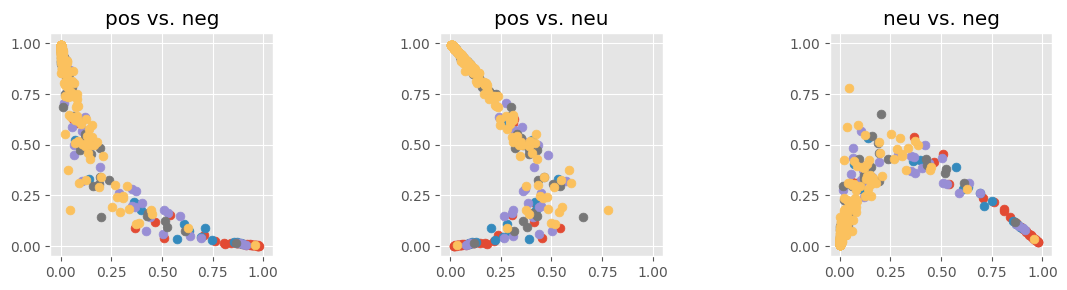

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].scatter(results_df['roberta_neg'][cut1], results_df['roberta_pos'][cut1], s=40, c='C0', marker='o', alpha=1)
axs[0].scatter(results_df['roberta_neg'][cut2], results_df['roberta_pos'][cut2], s=40, c='C1', marker='o', alpha=1)
axs[0].scatter(results_df['roberta_neg'][cut3], results_df['roberta_pos'][cut3], s=40, c='C2', marker='o', alpha=1)
axs[0].scatter(results_df['roberta_neg'][cut4], results_df['roberta_pos'][cut4], s=40, c='C3', marker='o', alpha=1)
axs[0].scatter(results_df['roberta_neg'][cut5], results_df['roberta_pos'][cut5], s=40, c='C4', marker='o', alpha=1)

axs[1].scatter(results_df['roberta_neu'][cut1], results_df['roberta_pos'][cut1], s=40, c='C0', marker='o', alpha=1)
axs[1].scatter(results_df['roberta_neu'][cut2], results_df['roberta_pos'][cut2], s=40, c='C1', marker='o', alpha=1)
axs[1].scatter(results_df['roberta_neu'][cut3], results_df['roberta_pos'][cut3], s=40, c='C2', marker='o', alpha=1)
axs[1].scatter(results_df['roberta_neu'][cut4], results_df['roberta_pos'][cut4], s=40, c='C3', marker='o', alpha=1)
axs[1].scatter(results_df['roberta_neu'][cut5], results_df['roberta_pos'][cut5], s=40, c='C4', marker='o', alpha=1)

axs[2].scatter(results_df['roberta_neg'][cut1], results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1)
axs[2].scatter(results_df['roberta_neg'][cut2], results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1)
axs[2].scatter(results_df['roberta_neg'][cut3], results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1)
axs[2].scatter(results_df['roberta_neg'][cut4], results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1)
axs[2].scatter(results_df['roberta_neg'][cut5], results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1)

axs[0].set(aspect='equal')
axs[1].set(aspect='equal')
axs[2].set(aspect='equal')

axs[0].set_xlim(-0.05, 1.05)
axs[1].set_xlim(-0.05, 1.05)
axs[2].set_xlim(-0.05, 1.05)

axs[0].set_ylim(-0.05, 1.05)
axs[1].set_ylim(-0.05, 1.05)
axs[2].set_ylim(-0.05, 1.05)

axs[0].set_xticks(np.arange(0, 1.01, .25))
axs[1].set_xticks(np.arange(0, 1.01, .25))
axs[2].set_xticks(np.arange(0, 1.01, .25))

axs[0].set_yticks(np.arange(0, 1.01, .25))
axs[1].set_yticks(np.arange(0, 1.01, .25))
axs[2].set_yticks(np.arange(0, 1.01, .25))

axs[0].set_title('pos vs. neg')
axs[1].set_title('pos vs. neu')
axs[2].set_title('neu vs. neg')
plt.tight_layout()
plt.show()

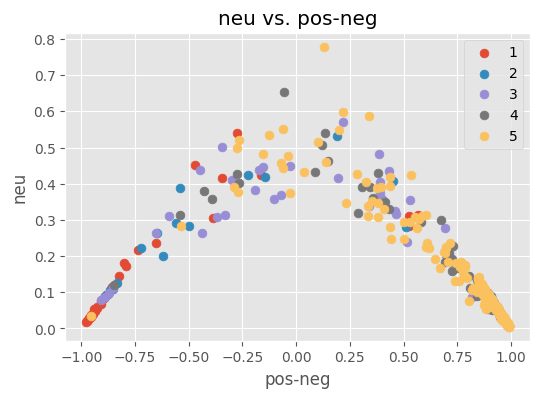

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos'][cut1]-results_df['roberta_neg'][cut1], results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1, label = '1')
plt.scatter(results_df['roberta_pos'][cut2]-results_df['roberta_neg'][cut2], results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1, label = '2')
plt.scatter(results_df['roberta_pos'][cut3]-results_df['roberta_neg'][cut3], results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1, label = '3')
plt.scatter(results_df['roberta_pos'][cut4]-results_df['roberta_neg'][cut4], results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1, label = '4')
plt.scatter(results_df['roberta_pos'][cut5]-results_df['roberta_neg'][cut5], results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1, label = '5')

plt.title('neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('neu')

plt.legend()

plt.show()

Let's check that pos+neg+neu does in fact equal 1

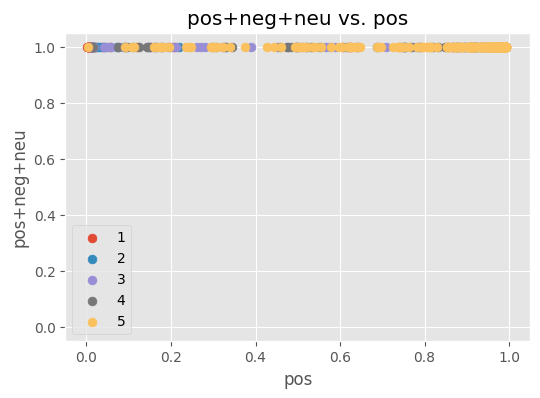

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos'][cut1], results_df['roberta_pos'][cut1]+results_df['roberta_neg'][cut1]+results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1, label = '1')
plt.scatter(results_df['roberta_pos'][cut2], results_df['roberta_pos'][cut2]+results_df['roberta_neg'][cut2]+results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1, label = '2')
plt.scatter(results_df['roberta_pos'][cut3], results_df['roberta_pos'][cut3]+results_df['roberta_neg'][cut3]+results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1, label = '3')
plt.scatter(results_df['roberta_pos'][cut4], results_df['roberta_pos'][cut4]+results_df['roberta_neg'][cut4]+results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1, label = '4')
plt.scatter(results_df['roberta_pos'][cut5], results_df['roberta_pos'][cut5]+results_df['roberta_neg'][cut5]+results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1, label = '5')

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.title('pos+neg+neu vs. pos')
plt.xlabel('pos')
plt.ylabel('pos+neg+neu')

plt.legend()

plt.show()

Good.

Now, since these points exist in the plane pos+neg+neu=1, lets look at how they look *in that plane* by choosing a new basis \
\
This plane is perpendicular to the vector [1,1,1].
The horizontal vector in this plane is [1,-1,0], so the vertical vector is the cross product, which is [1, 1, -2]. \
\
So we plot pos+neg-2*neu vs. pos-neg.

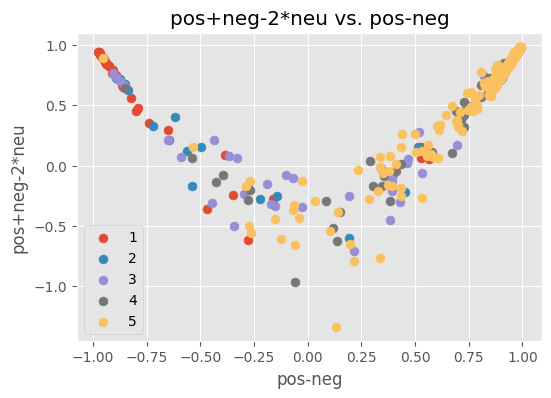

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos'][cut1]-results_df['roberta_neg'][cut1], results_df['roberta_pos'][cut1]+results_df['roberta_neg'][cut1]-2*results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1, label = '1')
plt.scatter(results_df['roberta_pos'][cut2]-results_df['roberta_neg'][cut2], results_df['roberta_pos'][cut2]+results_df['roberta_neg'][cut2]-2*results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1, label = '2')
plt.scatter(results_df['roberta_pos'][cut3]-results_df['roberta_neg'][cut3], results_df['roberta_pos'][cut3]+results_df['roberta_neg'][cut3]-2*results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1, label = '3')
plt.scatter(results_df['roberta_pos'][cut4]-results_df['roberta_neg'][cut4], results_df['roberta_pos'][cut4]+results_df['roberta_neg'][cut4]-2*results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1, label = '4')
plt.scatter(results_df['roberta_pos'][cut5]-results_df['roberta_neg'][cut5], results_df['roberta_pos'][cut5]+results_df['roberta_neg'][cut5]-2*results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1, label = '5')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

plt.legend()

plt.show()

Let's try a hyperbolic best fit to this scatterplot

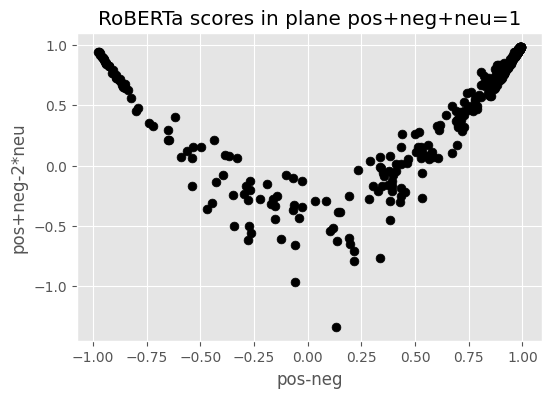

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos']-results_df['roberta_neg'], results_df['roberta_pos']+results_df['roberta_neg']-2*results_df['roberta_neu'], s=40, c='k', marker='o', alpha=1, label = 'data')

plt.title('RoBERTa scores in plane pos+neg+neu=1')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

#plt.legend()

plt.show()

In [ ]:
# Make values into numpy arrays
x_values = results_df['roberta_pos'].to_numpy()-results_df['roberta_neg'].to_numpy()
y_values = results_df['roberta_pos'].to_numpy()+results_df['roberta_neg'].to_numpy()-2*results_df['roberta_neu'].to_numpy()

# Define the fitting function
def hyperbola(x, a, b, k):
  return b*np.sqrt(1+x**2/a**2)+k

# Do the fit
popt, _ = curve_fit(hyperbola, x_values, y_values)

# Unpack the results
a, b, k = popt

# Make the best fit line into plottable data
x_fit = np.arange(-1., 1.01, 0.01)
y_fit = hyperbola(x_fit, a, b, k)

In [ ]:
print(a, b, k)

-0.5508669146140227 1.345497444368229 -1.7984662953417951


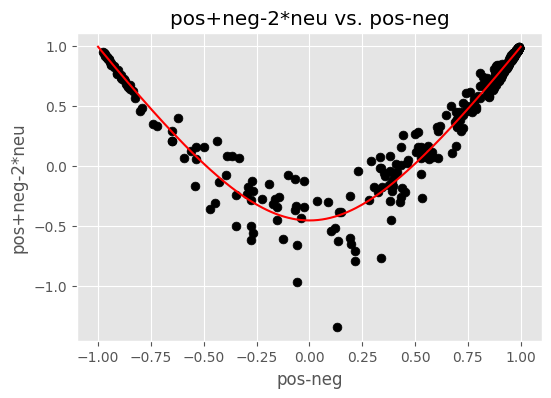

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos']-results_df['roberta_neg'], results_df['roberta_pos']+results_df['roberta_neg']-2*results_df['roberta_neu'], s=40, c='k', marker='o', alpha=1, label = 'data')
plt.plot(x_fit, y_fit, c='red')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

#plt.legend()

plt.show()

There is no analytic solution to the arc length of part of a hyperbola, so let's find each percentile of the arc length analytically. \

\
Each 2% of the arc will be 0.1 stars.

In [ ]:
xs_hyp = np.arange(-1., 1.001, 0.001)
ys_hyp = hyperbola(xs_hyp, a, b, k)
cumlen = np.zeros(xs_hyp.size)
a_size = xs_hyp.size

for i in range(xs_hyp.size-1):
  len = np.sqrt((xs_hyp[i+1]-xs_hyp[i])**2 + (ys_hyp[i+1]-ys_hyp[i])**2)
  cumlen[-a_size+1+i:] = np.add(cumlen[-a_size+1+i:], len*np.ones(a_size-1-i))

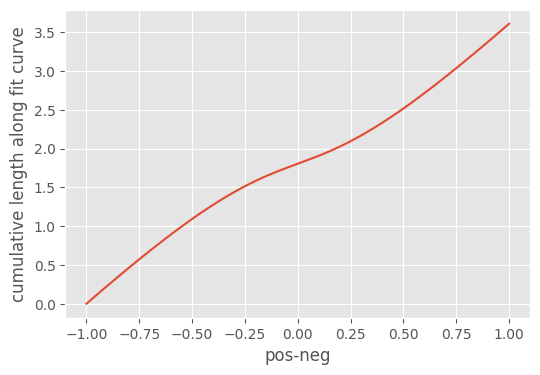

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.plot(xs_hyp, cumlen)

plt.xlabel('pos-neg')
plt.ylabel('cumulative length along fit curve')

plt.show()

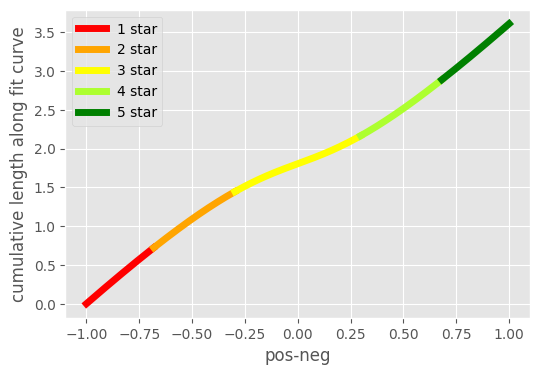

In [ ]:
# Showing what each amount of stars will look like according to this plot
max = np.max(cumlen)

cutoff_1_2 = np.argmax(cumlen>0.2*max)-1
cutoff_2_3 = np.argmax(cumlen>0.4*max)-1
cutoff_3_4 = np.argmax(cumlen>0.6*max)-1
cutoff_4_5 = np.argmax(cumlen>0.8*max)-1

fig = plt.figure(figsize=(6,4))

plt.plot(xs_hyp[:cutoff_1_2], cumlen[:cutoff_1_2], linewidth=5, c='red', label='1 star')
plt.plot(xs_hyp[cutoff_1_2+1:cutoff_2_3], cumlen[cutoff_1_2+1:cutoff_2_3], linewidth=5, c='orange', label='2 star')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], cumlen[cutoff_2_3+1:cutoff_3_4], linewidth=5, c='yellow', label='3 star')
plt.plot(xs_hyp[cutoff_3_4+1:cutoff_4_5], cumlen[cutoff_3_4+1:cutoff_4_5], linewidth=5, c='greenyellow', label='4 star')
plt.plot(xs_hyp[cutoff_4_5+1:], cumlen[cutoff_4_5+1:], linewidth=5, c='green', label='5 star')

plt.xlabel('pos-neg')
plt.ylabel('cumulative length along fit curve')

plt.legend()

plt.show()

In [ ]:
# Define functions for finding closest point on fit curve

# Dist squared formula
def dist2(x1, y1, x2, y2):
    return (x2-x1)**2+(y2-y1)**2

# Index of closest point on curve
def closest(x, y, xs, ys):
    dist = dist2(x, y, xs[0], ys[0])
    ind_close = 0
    for i in range(1, xs.shape[0]):
        new_dist = dist2(x, y, xs[i], ys[i])
        if new_dist < dist:
            dist = new_dist
            ind_close = i
    return ind_close

### Assigning each review its closest point on the fit curve

In [ ]:
res = {}
for i, row in tqdm(results_df.iterrows(), total=results_df.shape[0]):
    try:
        myid = row['Id']
        pos = row['roberta_pos']
        neg = row['roberta_neg']
        neu = row['roberta_neu']
        pos_neg = pos-neg
        pos_neg_2neu = pos+neg-2*neu

        ind_close = closest(pos_neg, pos_neg_2neu, xs_hyp, ys_hyp)
        star = round(5.0*(cumlen[ind_close]/np.max(cumlen)), 1)

        restar_dict = {
            'pos_neg' : pos_neg,
            'pos_neg_2neu' : pos_neg_2neu,
            'new_stars' : star
        }
        res[myid] = restar_dict
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
newstar_df = pd.DataFrame(res).T
newstar_df = newstar_df.reset_index().rename(columns={'index':'Id'})
newstar_df = newstar_df.merge(results_df, how='left')

In [ ]:
newstar_df.head()

,Id,pos_neg,pos_neg_2neu,new_stars,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.930771,0.850059,4.8,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,-0.470386,-0.357241,1.9,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.895475,0.705798,4.6,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.905190,0.729342,4.6,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.986428,0.969093,5.0,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
cut1_new = newstar_df['new_stars']<1.
cut2_new = (newstar_df['new_stars']>=1.) & (newstar_df['new_stars']<2.)
cut3_new = (newstar_df['new_stars']>=2.) & (newstar_df['new_stars']<3.)
cut4_new = (newstar_df['new_stars']>=3.) & (newstar_df['new_stars']<4.)
cut5_new = newstar_df['new_stars']>=4.

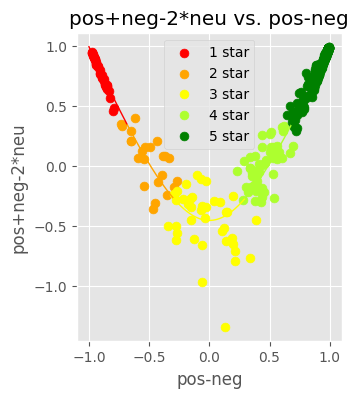

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(newstar_df['pos_neg'][cut1_new], newstar_df['pos_neg_2neu'][cut1_new], s=40, c='red', marker='o', alpha=1, label = '0-1 star')
plt.scatter(newstar_df['pos_neg'][cut2_new], newstar_df['pos_neg_2neu'][cut2_new], s=40, c='orange', marker='o', alpha=1, label = '1-2 star')
plt.scatter(newstar_df['pos_neg'][cut3_new], newstar_df['pos_neg_2neu'][cut3_new], s=40, c='yellow', marker='o', alpha=1, label = '2-3 star')
plt.scatter(newstar_df['pos_neg'][cut4_new], newstar_df['pos_neg_2neu'][cut4_new], s=40, c='greenyellow', marker='o', alpha=1, label = '3-4 star')
plt.scatter(newstar_df['pos_neg'][cut5_new], newstar_df['pos_neg_2neu'][cut5_new], s=40, c='green', marker='o', alpha=1, label = '4-5 star')

plt.plot(xs_hyp[:cutoff_1_2], ys_hyp[:cutoff_1_2], linewidth=1, c='red')
plt.plot(xs_hyp[cutoff_1_2+1:cutoff_2_3], ys_hyp[cutoff_1_2+1:cutoff_2_3], linewidth=1, c='orange')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], ys_hyp[cutoff_2_3+1:cutoff_3_4], linewidth=1, c='yellow')
plt.plot(xs_hyp[cutoff_3_4+1:cutoff_4_5], ys_hyp[cutoff_3_4+1:cutoff_4_5], linewidth=1, c='greenyellow')
plt.plot(xs_hyp[cutoff_4_5+1:], ys_hyp[cutoff_4_5+1:], linewidth=1, c='green')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

plt.gca().set_aspect('equal')

plt.legend()

plt.show()

It is ok to have dots of one color just over the boundary with another color. \
\
In the example below, the yellow dot (2.0 stars) at (-0.3, -0.23) is rounded up from about 1.95 stars, which is why it is closer to the orange portion of the curve.

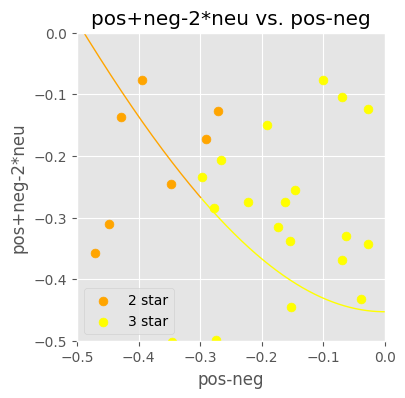

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(newstar_df['pos_neg'][cut2_new], newstar_df['pos_neg_2neu'][cut2_new], s=40, c='orange', marker='o', alpha=1, label = '2 star')
plt.scatter(newstar_df['pos_neg'][cut3_new], newstar_df['pos_neg_2neu'][cut3_new], s=40, c='yellow', marker='o', alpha=1, label = '3 star')

plt.plot(xs_hyp[cutoff_1_2+1:cutoff_2_3], ys_hyp[cutoff_1_2+1:cutoff_2_3], linewidth=1, c='orange')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], ys_hyp[cutoff_2_3+1:cutoff_3_4], linewidth=1, c='yellow')

#test_cut = cut2_new & (newstar_df['pos_neg_2neu']>-0.3) & (newstar_df['pos_neg_2neu']<=-0.27) & (newstar_df['pos_neg']>-0.3) & (newstar_df['pos_neg']<=-0.27)
#plt.scatter(newstar_df['pos_neg'][test_cut], newstar_df['pos_neg_2neu'][test_cut], s=40, c='k', marker='o', alpha=1, label = 'bad coord')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

plt.gca().set_aspect('equal')

plt.xlim(-0.5, 0.)
plt.ylim(-0.5, 0.)

plt.legend()

plt.show()

Oh shoot, Google doesn't allow 0 star reviews. We have to rescale from 1 to 5 stars.

## Rescaling from 1 to 5 stars

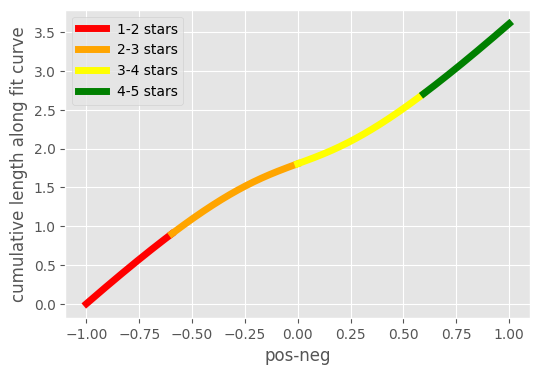

In [ ]:
# Showing what each amount of stars will look like according to this plot
max = np.max(cumlen)

cutoff_2_3 = np.argmax(cumlen>0.25*max)-1
cutoff_3_4 = np.argmax(cumlen>0.5*max)-1
cutoff_4_5 = np.argmax(cumlen>0.75*max)-1

fig = plt.figure(figsize=(6,4))

plt.plot(xs_hyp[:cutoff_2_3], cumlen[:cutoff_2_3], linewidth=5, c='red', label='1-2 stars')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], cumlen[cutoff_2_3+1:cutoff_3_4], linewidth=5, c='orange', label='2-3 stars')
plt.plot(xs_hyp[cutoff_3_4+1:cutoff_4_5], cumlen[cutoff_3_4+1:cutoff_4_5], linewidth=5, c='yellow', label='3-4 stars')
plt.plot(xs_hyp[cutoff_4_5+1:], cumlen[cutoff_4_5+1:], linewidth=5, c='green', label='4-5 stars')

plt.xlabel('pos-neg')
plt.ylabel('cumulative length along fit curve')

plt.legend()

plt.show()

## Assigning each review its closest point on the fit curve

In [ ]:
res = {}
for i, row in tqdm(results_df.iterrows(), total=results_df.shape[0]):
    try:
        myid = row['Id']
        pos = row['roberta_pos']
        neg = row['roberta_neg']
        neu = row['roberta_neu']
        pos_neg = pos-neg
        pos_neg_2neu = pos+neg-2*neu

        ind_close = closest(pos_neg, pos_neg_2neu, xs_hyp, ys_hyp)
        star = round(4.0*(cumlen[ind_close]/np.max(cumlen)), 1) + 1. # 4*frac+1 because 1<=stars<=5

        restar_dict = {
            'pos_neg' : pos_neg,
            'pos_neg_2neu' : pos_neg_2neu,
            'new_stars' : star
        }
        res[myid] = restar_dict
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/498 [00:00<?, ?it/s]

In [ ]:
rescale_df = pd.DataFrame(res).T
rescale_df = rescale_df.reset_index().rename(columns={'index':'Id'})
rescale_df = rescale_df.merge(results_df, how='left')

In [ ]:
rescale_df.head()

,Id,pos_neg,pos_neg_2neu,new_stars,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.930771,0.850059,4.8,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,-0.470386,-0.357241,2.6,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.895475,0.705798,4.7,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.905190,0.729342,4.7,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.986428,0.969093,5.0,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
cut1_2_re = rescale_df['new_stars']<2.
cut2_3_re = (rescale_df['new_stars']>=2.) & (rescale_df['new_stars']<3.)
cut3_4_re = (rescale_df['new_stars']>=3.) & (rescale_df['new_stars']<4.)
cut4_5_re = rescale_df['new_stars']>=4.

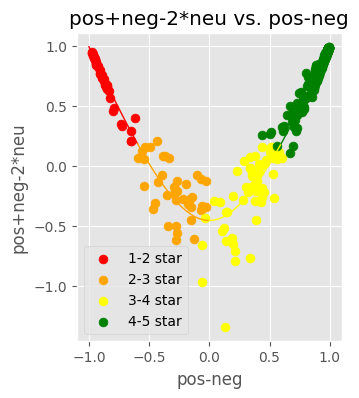

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(rescale_df['pos_neg'][cut1_2_re], rescale_df['pos_neg_2neu'][cut1_2_re], s=40, c='red', marker='o', alpha=1, label = '1-2 star')
plt.scatter(rescale_df['pos_neg'][cut2_3_re], rescale_df['pos_neg_2neu'][cut2_3_re], s=40, c='orange', marker='o', alpha=1, label = '2-3 star')
plt.scatter(rescale_df['pos_neg'][cut3_4_re], rescale_df['pos_neg_2neu'][cut3_4_re], s=40, c='yellow', marker='o', alpha=1, label = '3-4 star')
plt.scatter(rescale_df['pos_neg'][cut4_5_re], rescale_df['pos_neg_2neu'][cut4_5_re], s=40, c='green', marker='o', alpha=1, label = '4-5 star')

plt.plot(xs_hyp[:cutoff_2_3], ys_hyp[:cutoff_2_3], linewidth=1, c='red')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], ys_hyp[cutoff_2_3+1:cutoff_3_4], linewidth=1, c='orange')
plt.plot(xs_hyp[cutoff_3_4+1:cutoff_4_5], ys_hyp[cutoff_3_4+1:cutoff_4_5], linewidth=1, c='yellow')
plt.plot(xs_hyp[cutoff_4_5+1:], ys_hyp[cutoff_4_5+1:], linewidth=1, c='green')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

plt.gca().set_aspect('equal')

plt.legend()

plt.show()

It is ok to have dots of one color just over the boundary with another color. \
\
In the example below, the green (4-5 stars) at (0.56, 0.17) is rounded up from about 3.95 stars, which is why it is closer to the yellow portion of the curve.

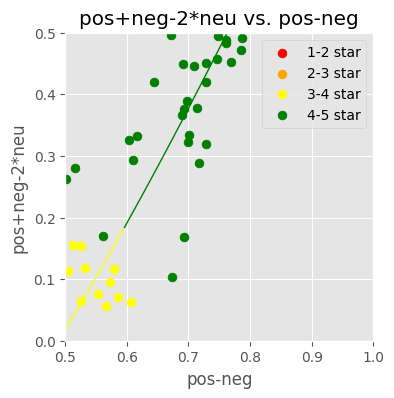

In [ ]:
fig = plt.figure(figsize=(6,4))

plt.scatter(rescale_df['pos_neg'][cut1_2_re], rescale_df['pos_neg_2neu'][cut1_2_re], s=40, c='red', marker='o', alpha=1, label = '1-2 star')
plt.scatter(rescale_df['pos_neg'][cut2_3_re], rescale_df['pos_neg_2neu'][cut2_3_re], s=40, c='orange', marker='o', alpha=1, label = '2-3 star')
plt.scatter(rescale_df['pos_neg'][cut3_4_re], rescale_df['pos_neg_2neu'][cut3_4_re], s=40, c='yellow', marker='o', alpha=1, label = '3-4 star')
plt.scatter(rescale_df['pos_neg'][cut4_5_re], rescale_df['pos_neg_2neu'][cut4_5_re], s=40, c='green', marker='o', alpha=1, label = '4-5 star')

plt.plot(xs_hyp[:cutoff_2_3], ys_hyp[:cutoff_2_3], linewidth=1, c='red')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], ys_hyp[cutoff_2_3+1:cutoff_3_4], linewidth=1, c='orange')
plt.plot(xs_hyp[cutoff_3_4+1:cutoff_4_5], ys_hyp[cutoff_3_4+1:cutoff_4_5], linewidth=1, c='yellow')
plt.plot(xs_hyp[cutoff_4_5+1:], ys_hyp[cutoff_4_5+1:], linewidth=1, c='green')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

plt.gca().set_aspect('equal')

plt.xlim(0.5, 1.)
plt.ylim(0., .5)

plt.legend()

plt.show()

## Roberta star rankings for each original star ranking

<Axes: xlabel='Score', ylabel='new_stars'>

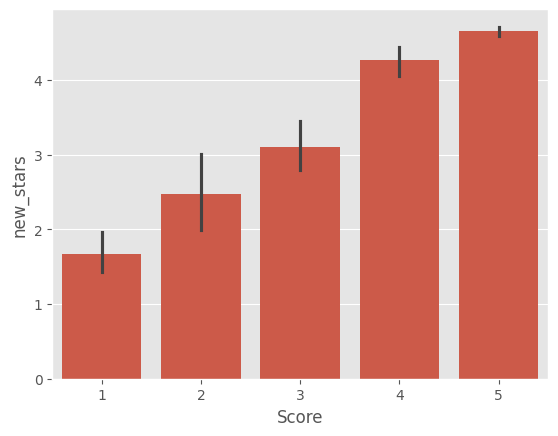

In [ ]:
sns.barplot(data=rescale_df, x='Score', y='new_stars')